## 1. 라이브러리 불러오기

In [1]:
!pip install tensorflow

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# 재현성
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 7.5 MB/s eta 0:00:0000:01m00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 5.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22/22 [tensorflow]2 [tensorflow]-py]a-server]


2025-09-02 10:00:18.455943: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 10:00:18.532803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-02 10:00:20.929027: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## 2. 데이터 불러오기 & EDA

In [2]:
import seaborn as sns

(x_train_eda, y_train_eda), (x_test_eda, y_test_eda) = reuters.load_data(num_words=None, test_split=0.2)

print("훈련 데이터 개수:", len(x_train_eda))
print("테스트 데이터 개수:", len(x_test_eda))
print("전체 클래스 개수:", np.max(y_train_eda) + 1)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
훈련 데이터 개수: 8982
테스트 데이터 개수: 2246
전체 클래스 개수: 46


- 레이블 분포 확인 (훈련 데이터의 클래스 분포)

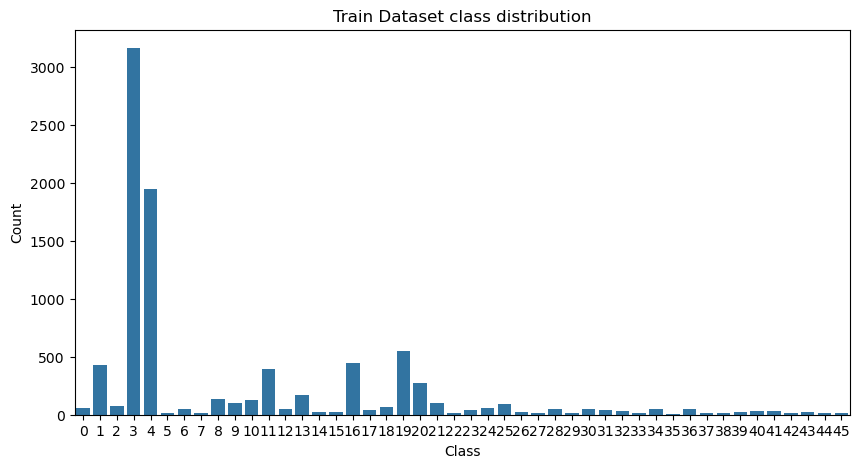

In [3]:
plt.figure(figsize=(10,5))
sns.countplot(x=y_train_eda)
plt.title("Train Dataset class distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

- 시퀀스 길이 분포 확인 (단어 개수 기준)

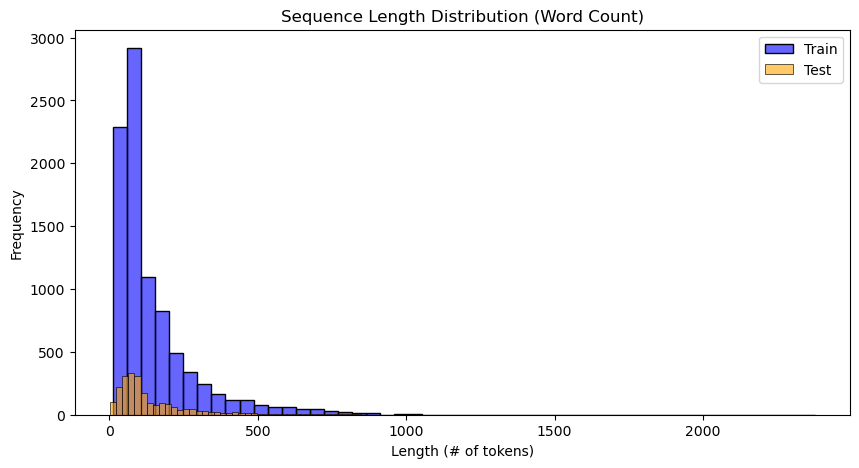

In [4]:
train_lengths = [len(seq) for seq in x_train_eda]
test_lengths  = [len(seq) for seq in x_test_eda]

plt.figure(figsize=(10,5))
sns.histplot(train_lengths, bins=50, color="blue", label="Train", alpha=0.6)
sns.histplot(test_lengths, bins=50, color="orange", label="Test", alpha=0.6)
plt.legend()
plt.title("Sequence Length Distribution (Word Count)")
plt.xlabel("Length (# of tokens)")
plt.ylabel("Frequency")
plt.show()

In [5]:
print("훈련 시퀀스 평균 길이:", np.mean(train_lengths))
print("훈련 시퀀스 중앙값 길이:", np.median(train_lengths))
print("테스트 시퀀스 평균 길이:", np.mean(test_lengths))
print("테스트 시퀀스 중앙값 길이:", np.median(test_lengths))

훈련 시퀀스 평균 길이: 145.5398574927633
훈련 시퀀스 중앙값 길이: 95.0
테스트 시퀀스 평균 길이: 147.66117542297417
테스트 시퀀스 중앙값 길이: 95.0


- 딥러닝에서 사용할 최적의 maxlen 계산 (90% 커버)

In [6]:
import numpy as np
recommended_maxlen = int(np.percentile(train_lengths, 90))
print("추천 maxlen (90% 시퀀스 커버):", recommended_maxlen)

추천 maxlen (90% 시퀀스 커버): 313


- 80% 커버 : 데이터의 대부분을 포함, 학습 속도/메모리 효율 ↑

- 90% 커버 : (가장 자주 쓰는 값) → 정보 보존과 효율성 균형

- 95% 이상 : 긴 문장까지 거의 다 포함하지만, 패딩 낭비가 커짐

## 3. (TF-IDF용) Reuters 단어 인덱스 로드 + 시퀀스를 문장으로 복원하기

In [7]:
# 단어 인덱스 (word -> index)
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {v+3: k for k, v in word_index.items()}                 # 원래 단어 인덱스에 특수 토큰 4개에 대한, 3개의 오프셋 추가
index_to_word[0] = "<PAD>"; index_to_word[1] = "<START>"; index_to_word[2] = "<UNK>"; index_to_word[3] = "<UNUSED>"

# 시퀀스 리스트를 공백 토큰 문자열로 복원
def decode_texts(seqs):
    out = []
    for s in seqs:
        out.append(" ".join(index_to_word.get(i, "<UNK>") for i in s))
    return out

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [8]:
print(decode_texts([[1, 4, 5]]))

['<START> the of']


In [9]:
# 레이블 분포 확인
# 데이터 프레임으로 묶어서 내림차순 정렬을 하면 가장 많은 뉴스 카테고리 TOP 10을 볼 수 있음
unique, counts = np.unique(y_train_eda, return_counts=True)
df_class_dist = pd.DataFrame({"class": unique, "count": counts}).sort_values("count", ascending=False)
print(df_class_dist.head(10))

    class  count
3       3   3159
4       4   1949
19     19    549
16     16    444
1       1    432
11     11    390
20     20    269
13     13    172
8       8    139
10     10    124


- 클래스 3, 4, 19 ... 순으로 뉴스 카테고리가 제일 많음

## 4. Vocab 사이즈, n-gram 설정 등을 변경하여 여러 모델에서 실험 진행하기

- vocab_size만 바꿔보았음 (None, 5000, 10000)
- vocab_size에서 None은 단어 개수 제한 없이 데이터셋에 있는 모든 단어를 그대로 가져옴 (Reuters 데이터셋은 약 26,000개의 단어라서 26K 단어를 사용함)
- n-gram을 (1,2)로 바꿔보려고 했으나 시간이 너무 오래 걸려서 코드로 남기기로 함
- n-gram을 (1,1)에서 (1,2)로 바꾸면 unigram과 bigram까지 사용하여 단어 조합 패턴까지 반영할 수 있음 (oil에서 oil prices까지 반영 가능)
- 그러므로 문맥 포착 능력이 증가함(oil prices가 자체적인 특징이 되어서 특정 주제 식별이 더 쉬워짐)

In [10]:
vocab_sizes = [None, 5000, 10000]  # 필요하면 2000/8000 등 더 추가
ngram_range = (1,1)                # 바꿔보며 영향 확인 가능 (1,2), (1,3) ...
results_table = []                 # 성능 로그를 여기에 누적
per_setting_reports = {}           # 각 세팅별 best 모델 리포트 저장

In [11]:
for vs in vocab_sizes:
    print("\n" + "="*80)
    print(f"[실험] vocab_size (Reuters num_words) = {vs}")
    print("="*80)
    
    # 데이터 로드 (num_words=vs)
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=vs, test_split=0.2)
    
    # 텍스트 복원 → TF-IDF 벡터화
    train_texts = decode_texts(x_train)
    test_texts  = decode_texts(x_test)
    
    # max_features를 vs로 맞춰 사실상 vocab 크기 유사 제어 (vs=None이면 제한 없음)
    vectorizer = TfidfVectorizer(max_features=vs, ngram_range=ngram_range)
    X_train = vectorizer.fit_transform(train_texts)
    X_test  = vectorizer.transform(test_texts)
    
    print(f"TF-IDF shape: train={X_train.shape}, test={X_test.shape}")
    
    # 모델 정의 (총 8개)
    models = {
        "MNB": MultinomialNB(),
        "CNB": ComplementNB(),
        "LogReg": LogisticRegression(max_iter=2000),
        "LinearSVC": LinearSVC(),
        "DecisionTree": DecisionTreeClassifier(random_state=SEED),
        "RandomForest": RandomForestClassifier(n_estimators=400, random_state=SEED, n_jobs=-1),
        "GradientBoosting": GradientBoostingClassifier(random_state=SEED),
        # Soft Voting은 확률 출력 가능한 모델로 구성
        "VotingSoft": VotingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=2000)),
                ("rf", RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1)),
                ("mnb", MultinomialNB())
            ],
            voting="soft",
            n_jobs=-1
        )
    }
    
    # 학습 및 평가
    best_row = None
    best_name = None
    best_pred = None

    # 각 모델을 같은 TF-IDF 피처로 학습 및 평가
    for name, clf in models.items():
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        acc = accuracy_score(y_test, pred)
        f1m = f1_score(y_test, pred, average="macro")
        results_table.append({"vocab_size": str(vs), "model": name, "accuracy": acc, "f1_macro": f1m})
        print(f"[{name:14s}] acc={acc:.4f} | f1_macro={f1m:.4f}")
        
        # 최고 모델 찾기 (F1을 적용하되, 동률이면 Acc 적용)
        if (best_row is None) or (f1m > best_row["f1_macro"]) or (np.isclose(f1m, best_row["f1_macro"]) and acc > best_row["accuracy"]):
            best_row = {"accuracy": acc, "f1_macro": f1m}
            best_name = name
            best_pred = pred
    
    # 세팅별 최고 모델 리포트 저장
    report = classification_report(y_test, best_pred, zero_division=0, digits=4)
    per_setting_reports[str(vs)] = {
        "best_model": best_name,
        "accuracy": best_row["accuracy"],
        "f1_macro": best_row["f1_macro"],
        "report": report
    }
    
    print("\n[세팅별 최고] vocab_size=", vs, "| model=", best_name, "| acc=", f"{best_row['accuracy']:.4f}", "| f1_macro=", f"{best_row['f1_macro']:.4f}")
    print(report)


[실험] vocab_size (Reuters num_words) = None
TF-IDF shape: train=(8982, 26505), test=(2246, 26505)
[MNB           ] acc=0.5997 | f1_macro=0.0677
[CNB           ] acc=0.7645 | f1_macro=0.4619
[LogReg        ] acc=0.7925 | f1_macro=0.4583
[LinearSVC     ] acc=0.8295 | f1_macro=0.6887
[DecisionTree  ] acc=0.7057 | f1_macro=0.4435
[RandomForest  ] acc=0.7458 | f1_macro=0.4141
[GradientBoosting] acc=0.7694 | f1_macro=0.5846
[VotingSoft    ] acc=0.7044 | f1_macro=0.2587

[세팅별 최고] vocab_size= None | model= LinearSVC | acc= 0.8295 | f1_macro= 0.6887
              precision    recall  f1-score   support

           0     0.8889    0.6667    0.7619        12
           1     0.7304    0.8000    0.7636       105
           2     0.8421    0.8000    0.8205        20
           3     0.9342    0.9434    0.9388       813
           4     0.8135    0.8924    0.8511       474
           5     0.0000    0.0000    0.0000         5
           6     0.9286    0.9286    0.9286        14
           7     1.0

[결과 해석]
- 최고 성능 모델 : LinearSVC / 정확도는 약 0.83으로 비슷하지만 Macro-F1에서는 전체 Vocab을 사용한 것이 조금 더 높았음 (0.6887)
  
- Reuters 데이터셋의 클래스 불균형이 크지만, Macro-F1은 소수 클래스 성능을 균등하게 반영함
- 다수 클래스(특히 3, 4)에서 점수가 좋아도 소수 클래스에서 잘 못 예측하면 점수가 금방 하락하게 됨
  
- 대부분의 모델이 다수 클래스에서는 Precision, Recall, F1 모두가 높음
- 하지만 소수 클래스에서는 예측이 불안정함 → n-gram을 확장하거나 ```class_weight='balanced'```를 적용해서 소수 클래스 재현율을 보강하는 대안 적용

## 5. 결과 종합표 및 성능 시각화

[최고 성능 모델]

- 전체 vocab_size 모두 공통적으로 LinearSVC가 가장 우수
- Accuracy ≈ 0.83, Macro-F1 ≈ 0.68 → TF-IDF + LinearSVC 조합이 이 데이터셋의 최적 베이스라인임을 확인함

[GradientBoosting]
- Accuracy는 0.760.77대, Macro-F1은 0.560.58대
- 소수 클래스까지 비교적 잘 잡는 편이지만 LinearSVC보다 전반적으로 낮음

[LogisticRegression, CNB]
- Accuracy는 0.770.80 수준으로 나쁘지 않으나, Macro-F1은 0.470.48로 소수 클래스 성능이 떨어짐

[Tree 기반 모델 (DecisionTree, RandomForest)]
- Accuracy 0.690.76, Macro-F1 0.430.45
- 고차원 희소 벡터 환경에서 성능이 제한적임을 보여줌

[VotingSoft]
- Accuracy 0.730.75, Macro-F1 0.300.32
- 오히려 단일 모델보다 성능 저하가 발생함

[MNB]
- Accuracy 0.65~0.67, Macro-F1 0.10 수준
- 다수 클래스에는 강하지만 소수 클래스 예측은 거의 실패

,vocab_size,model,accuracy,f1_macro
0,10000,LinearSVC,0.829920,0.680843
1,10000,GradientBoosting,0.764025,0.567663
2,10000,CNB,0.770703,0.478358
3,10000,LogReg,0.795637,0.472114
4,10000,DecisionTree,0.688780,0.436547
5,10000,RandomForest,0.756456,0.428819
6,10000,VotingSoft,0.733749,0.301361
7,10000,MNB,0.657168,0.096870
8,5000,LinearSVC,0.829029,0.681329
9,5000,GradientBoosting,0.763134,0.563636


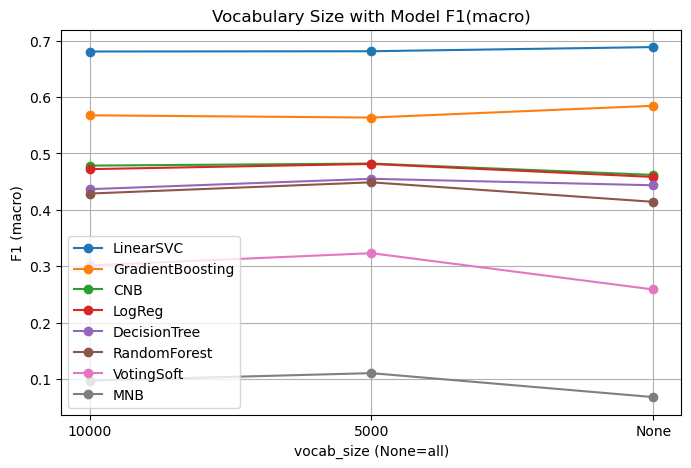

In [12]:
all_df = pd.DataFrame(results_table).sort_values(["vocab_size", "f1_macro", "accuracy"], ascending=[True, False, False]).reset_index(drop=True)
display(all_df.head(20))

# 모델별 F1 추이
plt.figure(figsize=(8,5))
for m in all_df["model"].unique():
    sub = all_df[all_df["model"]==m]
    xs = sub["vocab_size"].tolist()
    ys = sub["f1_macro"].tolist()
    plt.plot(xs, ys, marker="o", label=m)
plt.title("Vocabulary Size with Model F1(macro)")
plt.xlabel("vocab_size (None=all)")
plt.ylabel("F1 (macro)")
plt.legend()
plt.grid(True)
plt.show()

## 6. 딥러닝 모델과 비교하기 (동일 데이터 및 전처리 적용)

- 위에서 뽑힌 최적의 ```vocab_size=None```으로 1D CNN을 비교함
- 사전 학습 임베딩 등 사용 X

In [27]:
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

In [28]:
# 데이터 로드 - 단어 수 제한 없음
(x_train_all, y_train_all), (x_test_dl, y_test_dl) = reuters.load_data(
    num_words=None,
    test_split=0.2
)

# train/val 분할
Xtr, Xva, ytr, yva = train_test_split(
    x_train_all, y_train_all,
    test_size=0.1,
    random_state=42,
    stratify=y_train_all
)

In [29]:
# 패딩
maxlen = 313
Xtr = pad_sequences(Xtr, maxlen=maxlen)
Xva = pad_sequences(Xva, maxlen=maxlen)
x_test_dl = pad_sequences(x_test_dl, maxlen=maxlen)

# 임베딩 input_dim 계산
vocab_size_for_embedding = int(max(Xtr.max(), Xva.max(), x_test_dl.max())) + 1

# 클래스 개수
num_classes = int(np.max(y_train_all)) + 1

print("num_classes =", num_classes)
print("vocab_size_for_embedding =", vocab_size_for_embedding)
print("max token id seen =", int(max(Xtr.max(), Xva.max(), x_test_dl.max())))

num_classes = 46
vocab_size_for_embedding = 30982
max token id seen = 30981


In [30]:
# 1D-CNN 모델
cnn = models.Sequential([
    layers.Embedding(input_dim=vocab_size_for_embedding, output_dim=128),
    layers.Conv1D(128, 5, activation="relu"),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 5, activation="relu"),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

hist = cnn.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=6,
    batch_size=256,
    verbose=1
)

Epoch 1/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 812ms/step - accuracy: 0.3784 - loss: 2.6692 - val_accuracy: 0.5028 - val_loss: 2.0158
Epoch 2/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 804ms/step - accuracy: 0.5134 - loss: 1.9562 - val_accuracy: 0.5273 - val_loss: 1.7968
Epoch 3/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 803ms/step - accuracy: 0.5602 - loss: 1.7125 - val_accuracy: 0.5873 - val_loss: 1.6371
Epoch 4/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 822ms/step - accuracy: 0.6162 - loss: 1.5058 - val_accuracy: 0.6140 - val_loss: 1.5864
Epoch 5/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 811ms/step - accuracy: 0.6725 - loss: 1.3325 - val_accuracy: 0.6418 - val_loss: 1.5377
Epoch 6/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 813ms/step - accuracy: 0.7225 - loss: 1.1624 - val_accuracy: 0.6418 - val_loss: 1.5075


In [31]:
# 평가
proba = cnn.predict(x_test_dl, verbose=0)
pred = np.argmax(proba, axis=1)
acc = accuracy_score(y_test_dl, pred)
f1m = f1_score(y_test_dl, pred, average="macro")
print("\n[딥러닝 1D-CNN | vocab=None, stratified split] acc=", f"{acc:.4f}", " | f1_macro=", f"{f1m:.4f}")
print(classification_report(y_test_dl, pred, zero_division=0, digits=4))


[딥러닝 1D-CNN | vocab=None, stratified split] acc= 0.6576  | f1_macro= 0.0928
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        12
           1     0.2665    0.8095    0.4009       105
           2     0.0000    0.0000    0.0000        20
           3     0.8968    0.9508    0.9230       813
           4     0.8208    0.8502    0.8352       474
           5     0.0000    0.0000    0.0000         5
           6     0.0000    0.0000    0.0000        14
           7     0.0000    0.0000    0.0000         3
           8     0.0000    0.0000    0.0000        38
           9     0.0000    0.0000    0.0000        25
          10     0.6154    0.2667    0.3721        30
          11     0.2475    0.6024    0.3509        83
          12     0.0000    0.0000    0.0000        13
          13     0.0714    0.0270    0.0392        37
          14     0.0000    0.0000    0.0000         2
          15     0.0000    0.0000    0.0000         9
    

- CNN 모델이 테스트셋 전체 기준으로는 약 66%의 정확도를 달성, 하지만 Macro-F1이 0.0928로 매우 낮음
- 다수 클래스에서는 Precision과 Recall이 모두 높은데, 소수 클래스에서는 전혀 예측하지 못했음
- ```class_weight='balanced```를 추가하여 소수 클래스에 더 큰 학습 비중을 부여한다면 성능이 개선되지 않을까 생각함
- 혹은 데이터 증강이나 오버 샘플링을 통해 소수 클래스의 샘플 수를 늘리는 것도 좋을 것 같음

## 7. 회고

- LinearSVC : Accuracy 0.83, Macro-F1 ≈ 0.69 → ML 모델 중 최적의 모델이자, 소수 클래스도 일정 수준 커버함
- Gradient Boosting : Macro-F1 0.56 ~ 0.58으로 차선책이 될 수 있음
- 1D-CNN : Accuracy 0.66, Macro-F1 0.09으로 전통 ML보다 훨씬 낮으며, 다수 클래스만 집중적으로 잘 맞춤

- 피어 리뷰 시간에 다른 팀원들의 이야기를 들어보니 vocab_size는 일정 수준 이상이 되면 오히려 성능이 하락했음
- 유니그램이나 바이그램을 시도해보고 싶은데 매우 오래 걸려서 실험을 하지 못해 매우 아쉬움
- CNN 말고 RNN 계열로 실험했다면 조금 더 성능이 좋았을까 궁금해짐